In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import albumentations as A
from albumentations import Compose, HorizontalFlip, RandomRotate90, ColorJitter, RandomCrop, GaussianBlur, Normalize
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os.path
from PIL import Image, ImageDraw
from sahi.utils.file import load_json, save_json
from tqdm import tqdm

import torchvision
import torch


In [3]:
torch.cuda.is_available()
torch.cuda.current_device()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
coco_file_name = "cassette1_val"

original_file = f"{coco_file_name}_corrected_coco.json"
sliced_file = f"{coco_file_name}_sliced_coco.json"

DATA_COCO_DIR = os.path.join("...", "data", "coco")
DATA_DIR = os.path.join("...","data")

ORG_ANNOTATION_PATH = os.path.join(DATA_COCO_DIR, original_file)
SLC_ANNOTATION_PATH  = os.path.join(DATA_COCO_DIR, sliced_file)
AUGMENTATION_PATH =  os.path.join("...", "data","augmentation")
IMAGE_DIR = os.path.join(DATA_COCO_DIR, "images") 
SLICED_IMAGE_DIR = os.path.join(DATA_COCO_DIR, "images_sliced",coco_file_name) 
VISUALISATION_DIR = os.path.join("...", "data", "bbox_vis")
VISUALISATION_FILE = os.path.join(VISUALISATION_DIR, coco_file_name)

# Ensure directories exist
os.path.exists(DATA_DIR)
os.path.exists(AUGMENTATION_PATH)
os.path.exists(IMAGE_DIR)
os.path.exists(VISUALISATION_DIR)
os.path.exists(VISUALISATION_FILE)



False

## Full image augmentation

In [13]:
coco_dict = load_json(ORG_ANNOTATION_PATH)

coco_dict

FileNotFoundError: [Errno 2] No such file or directory: '.\\data\\coco\\cassette1_val_corrected_coco.json'

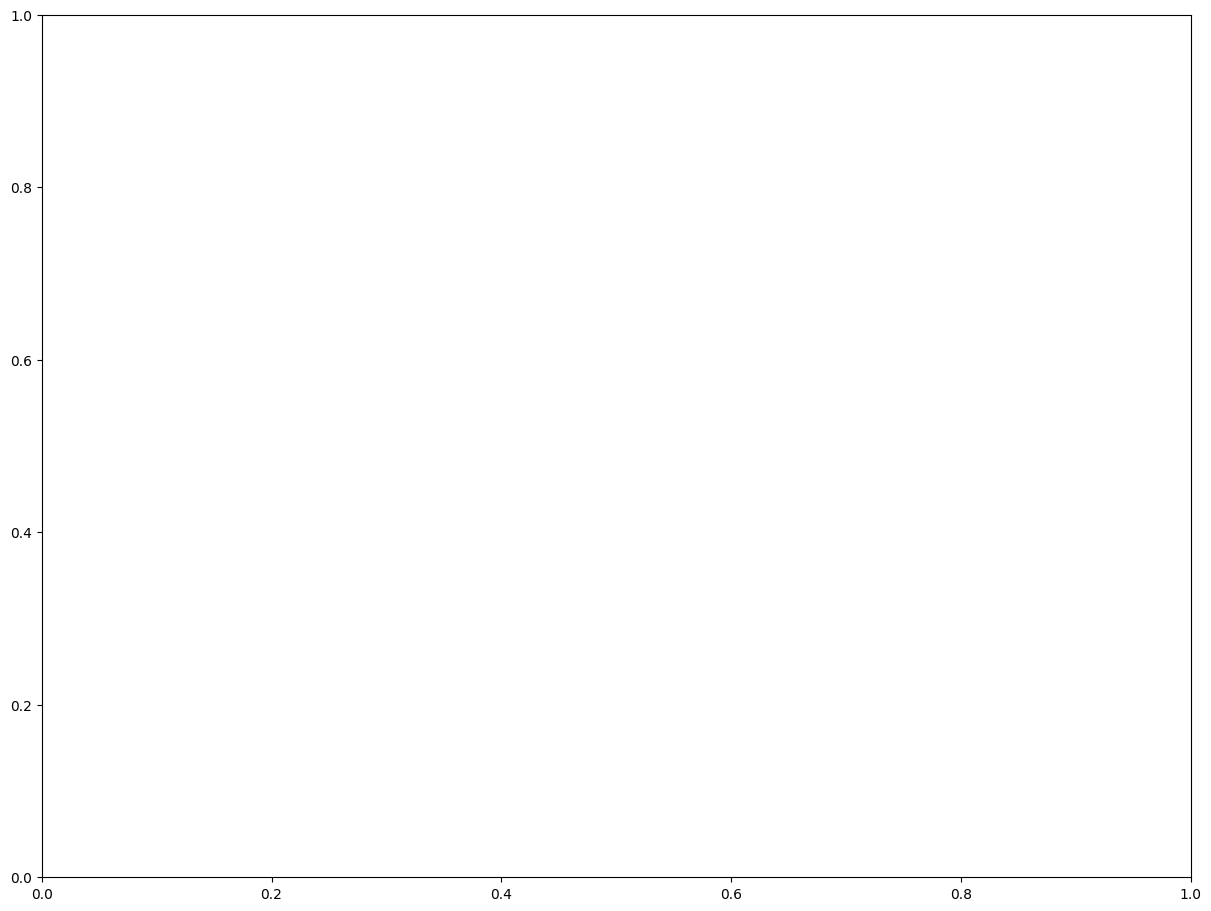

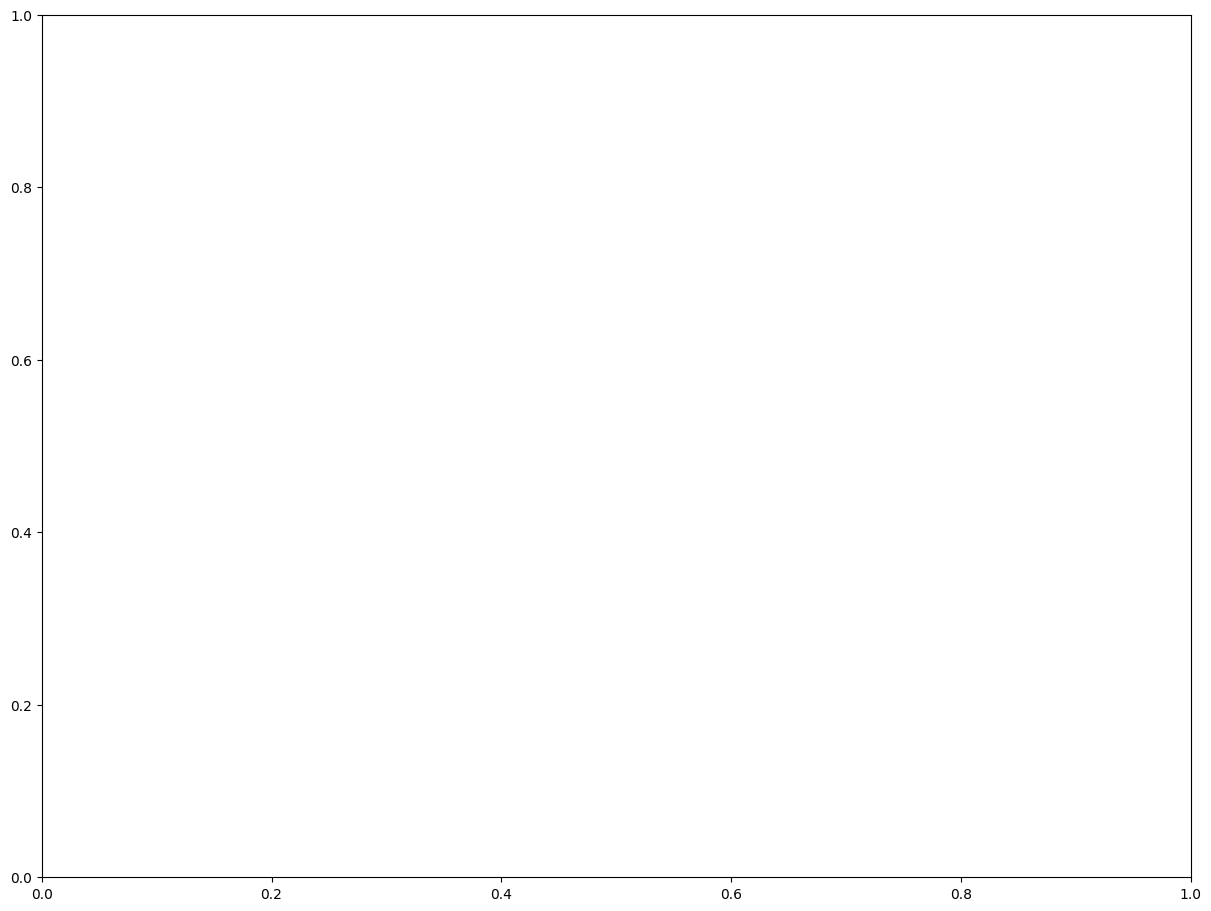

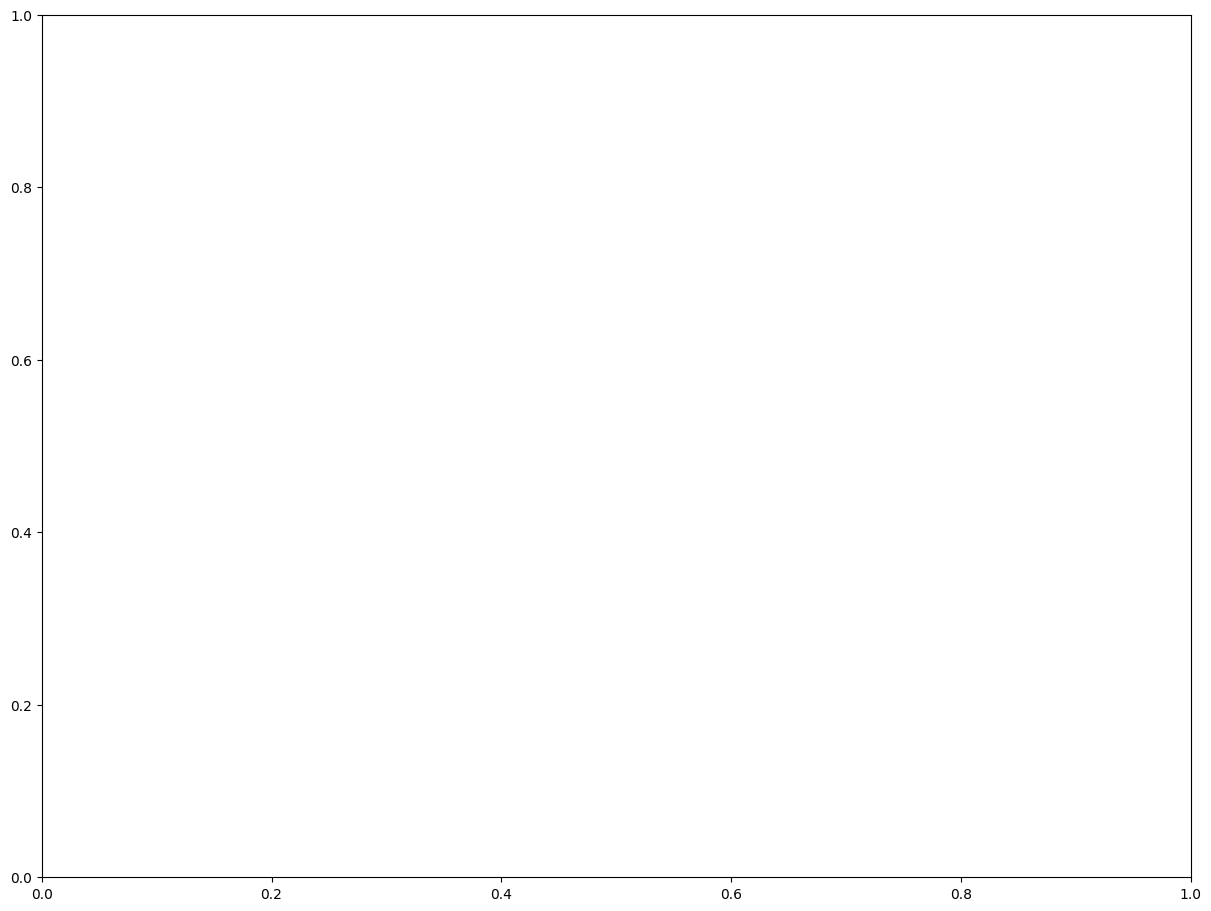

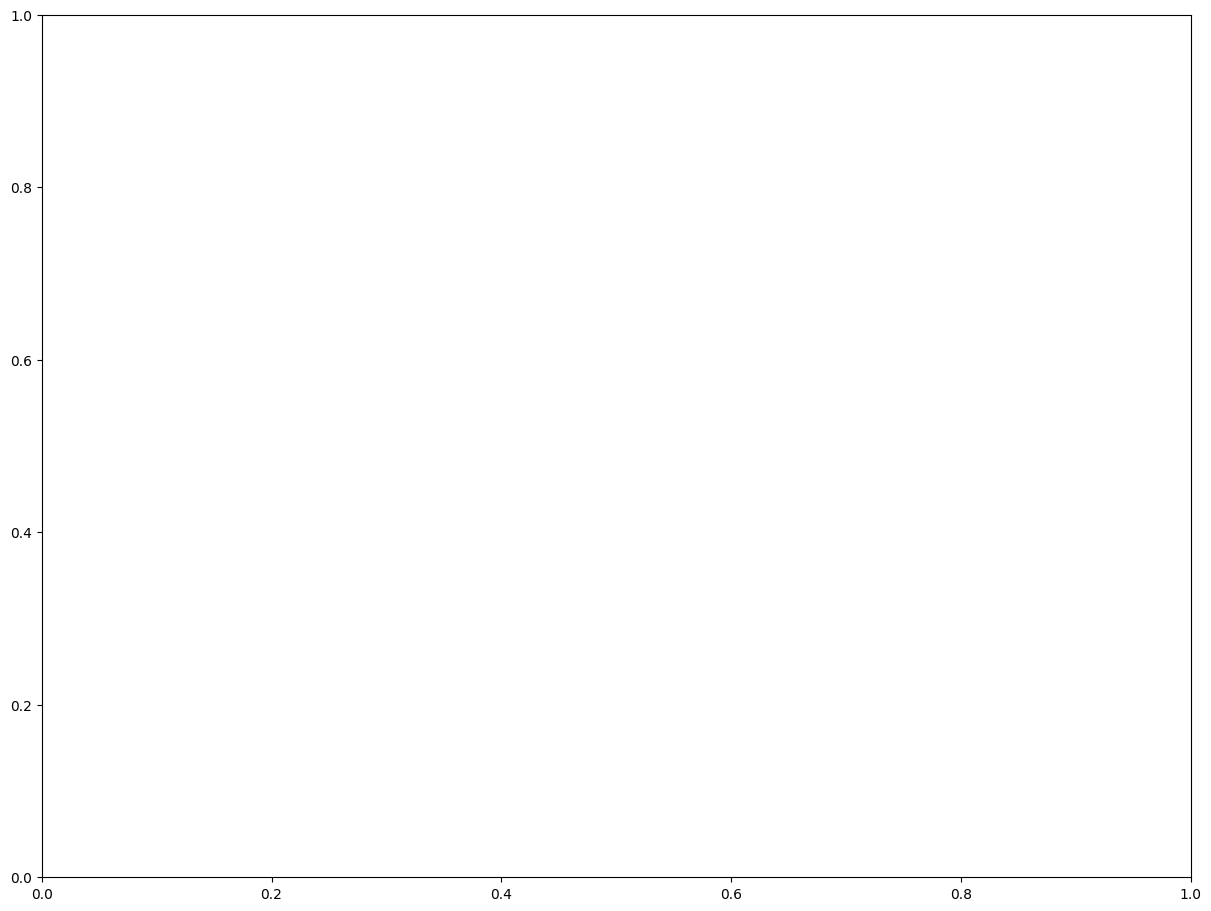

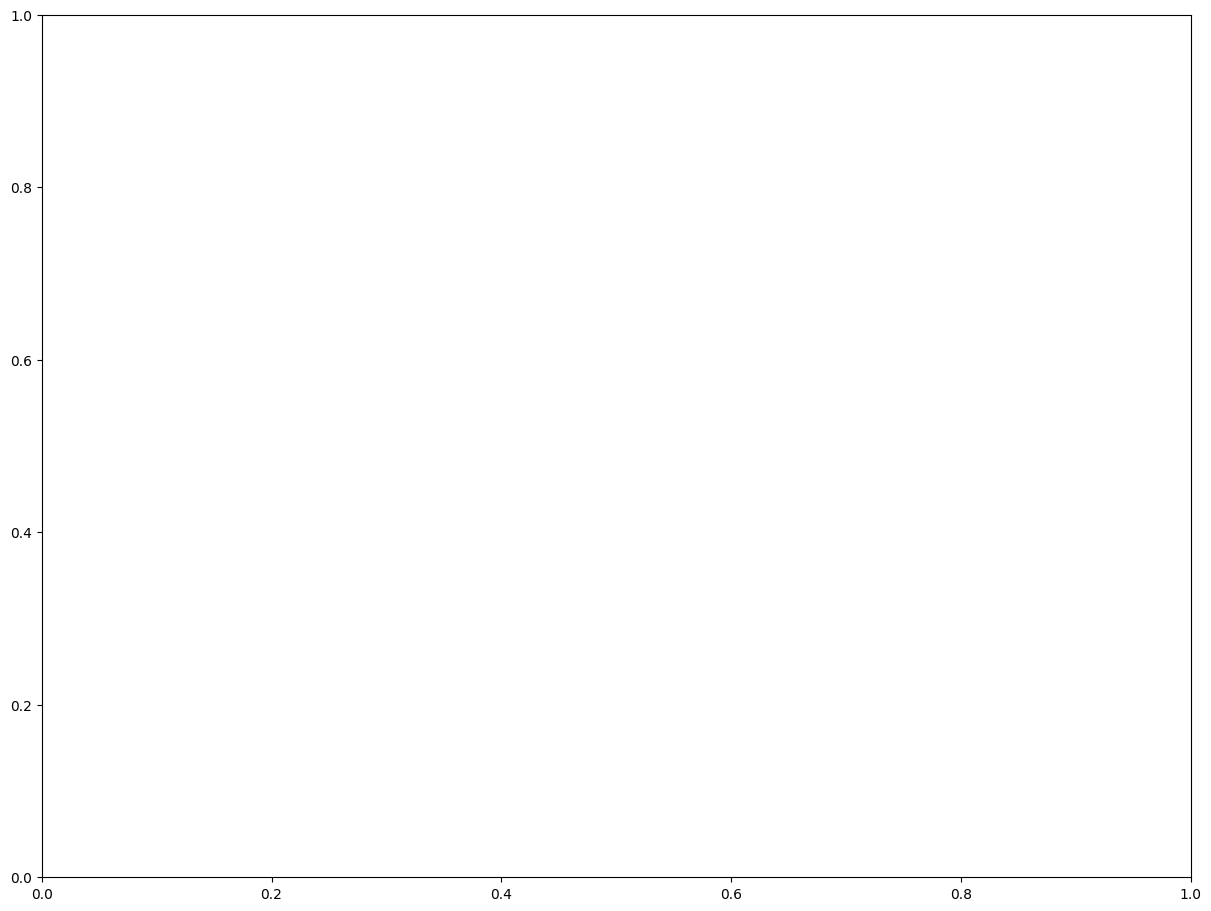

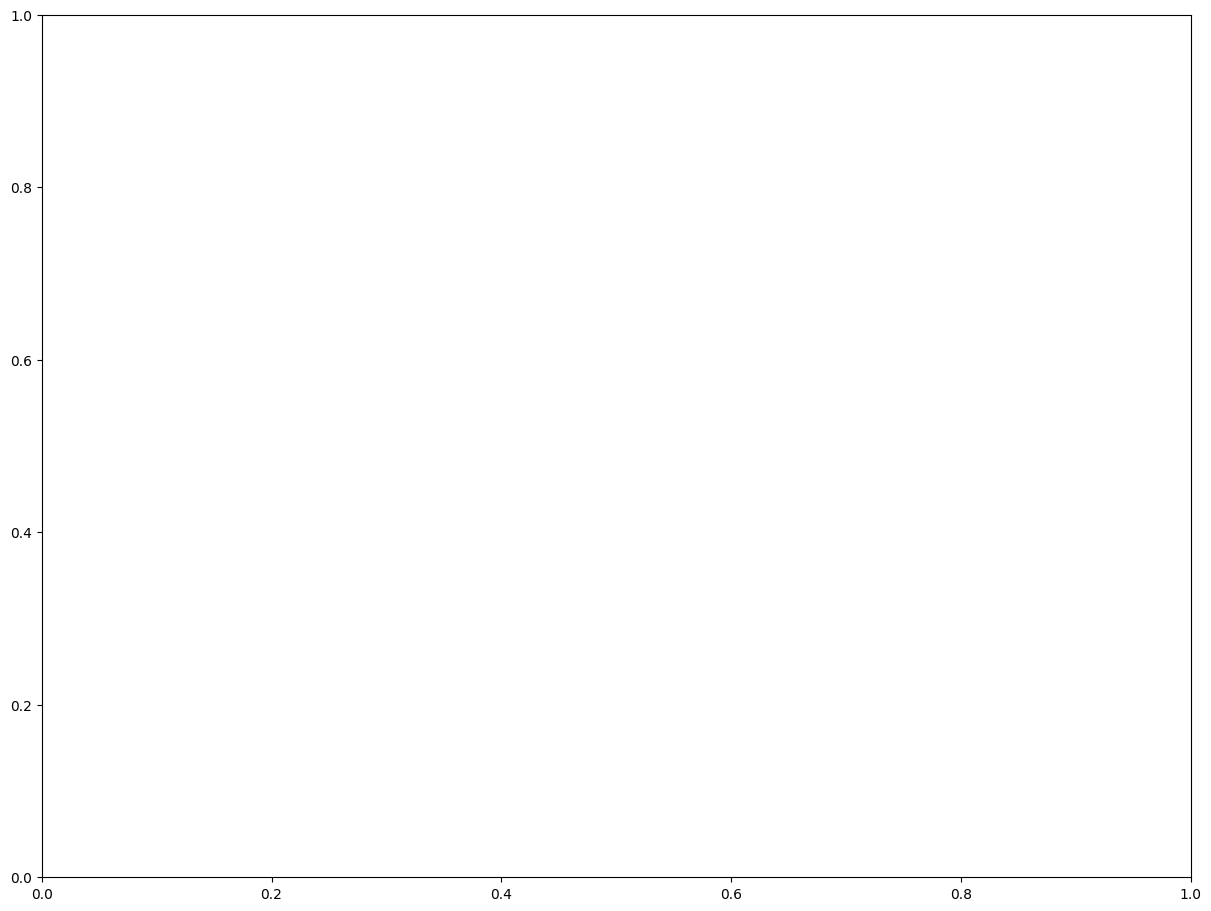

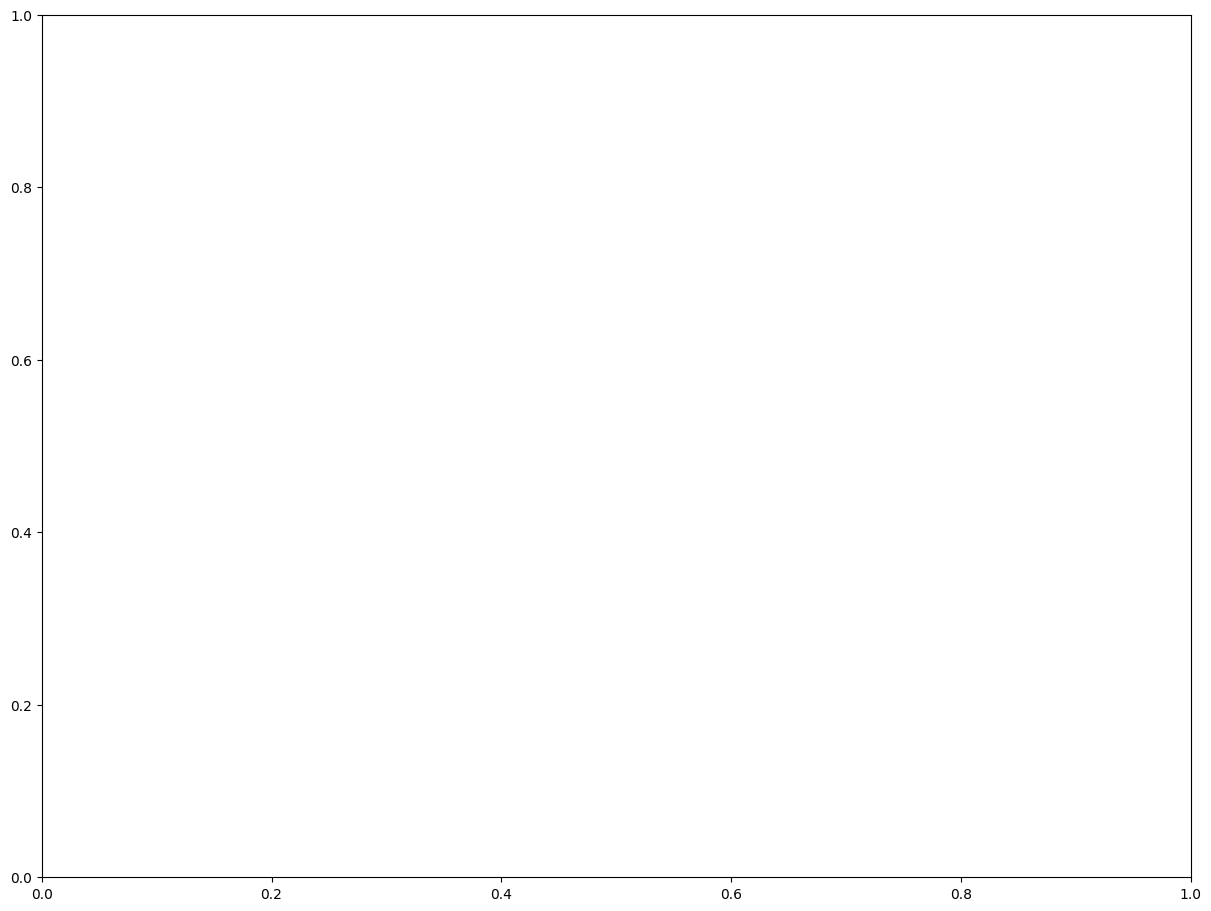

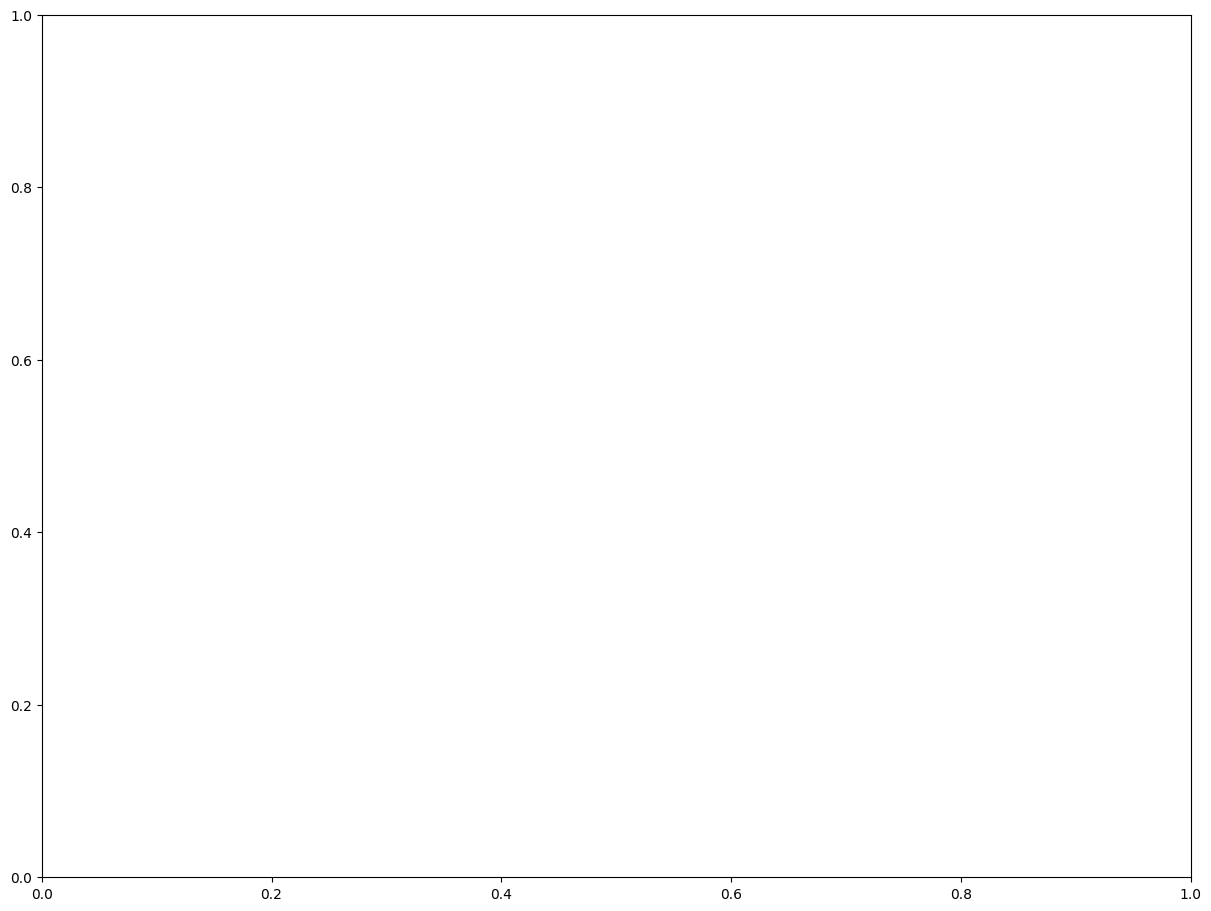

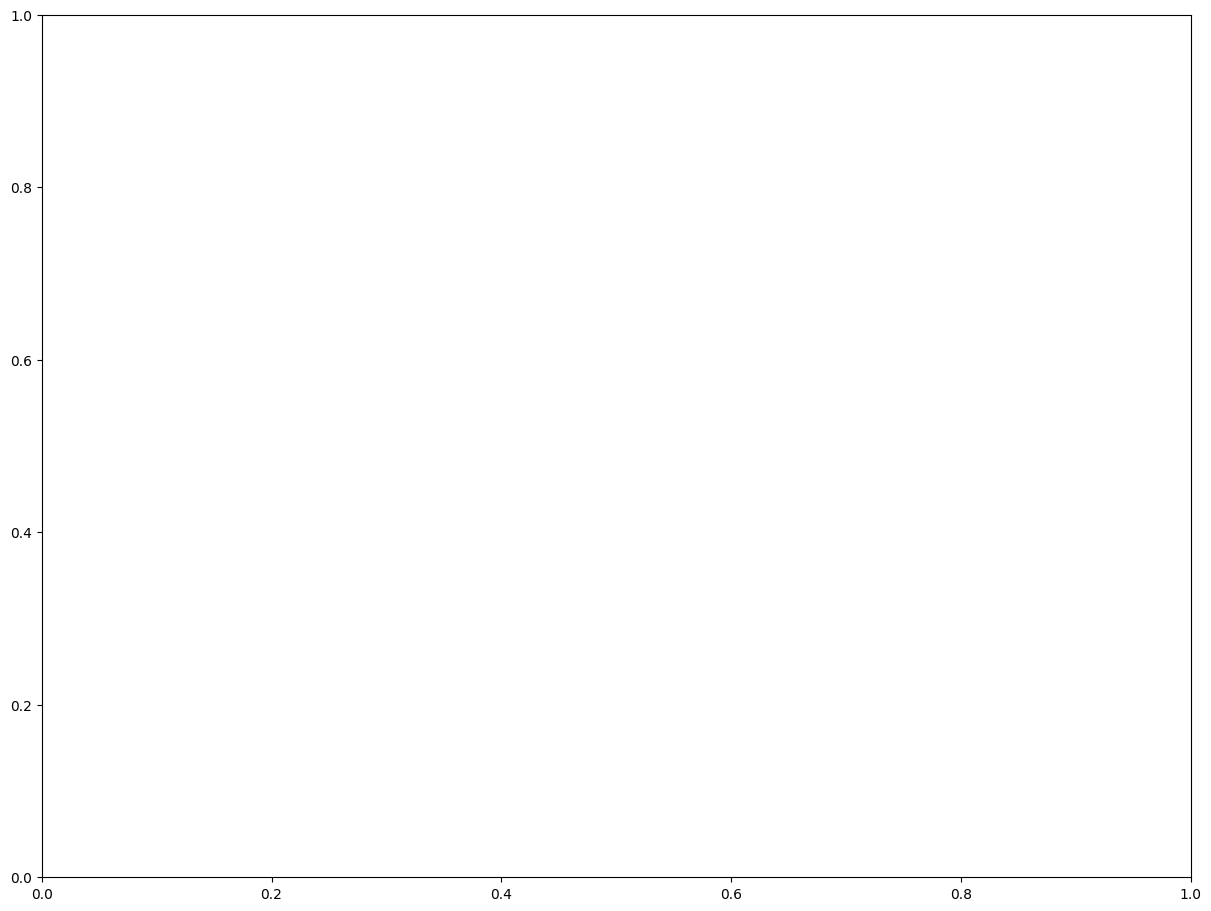

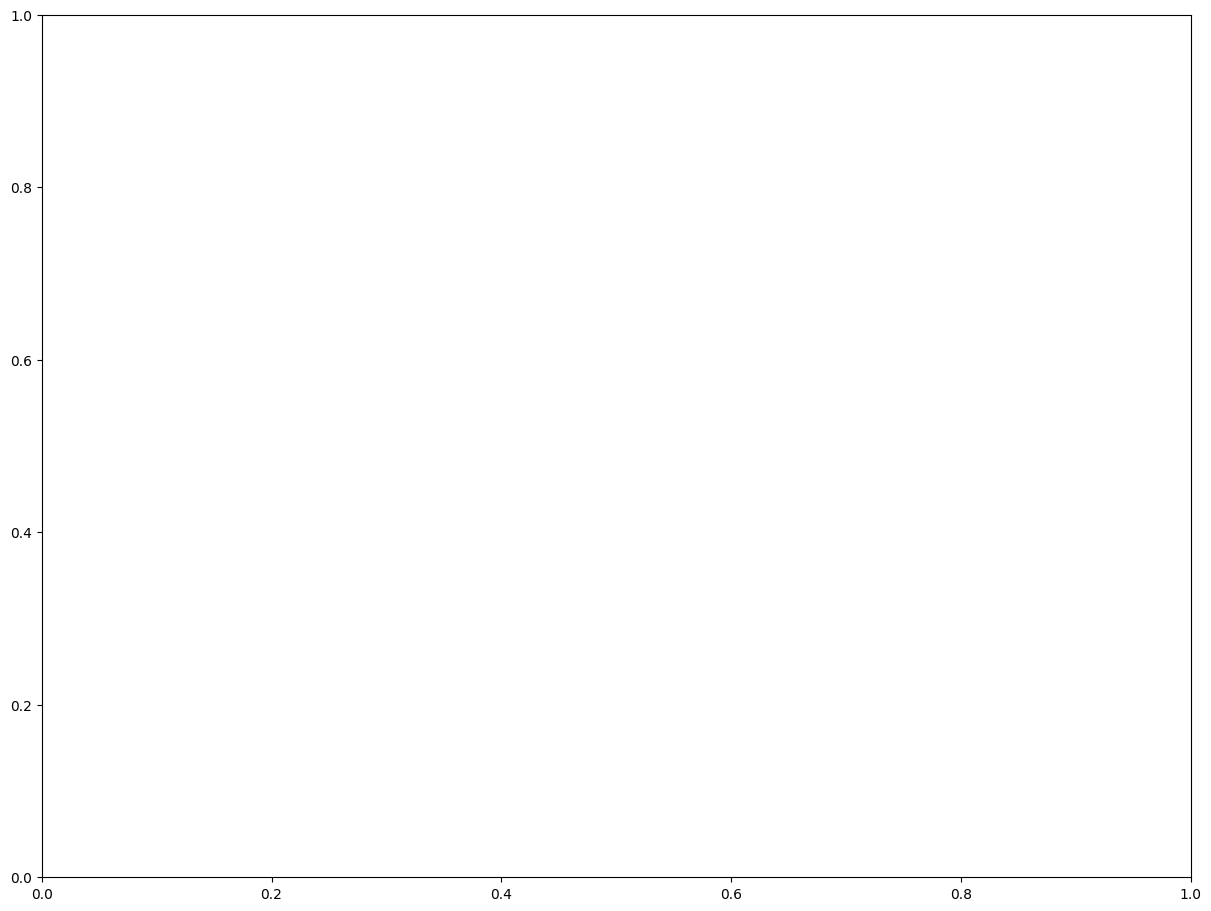

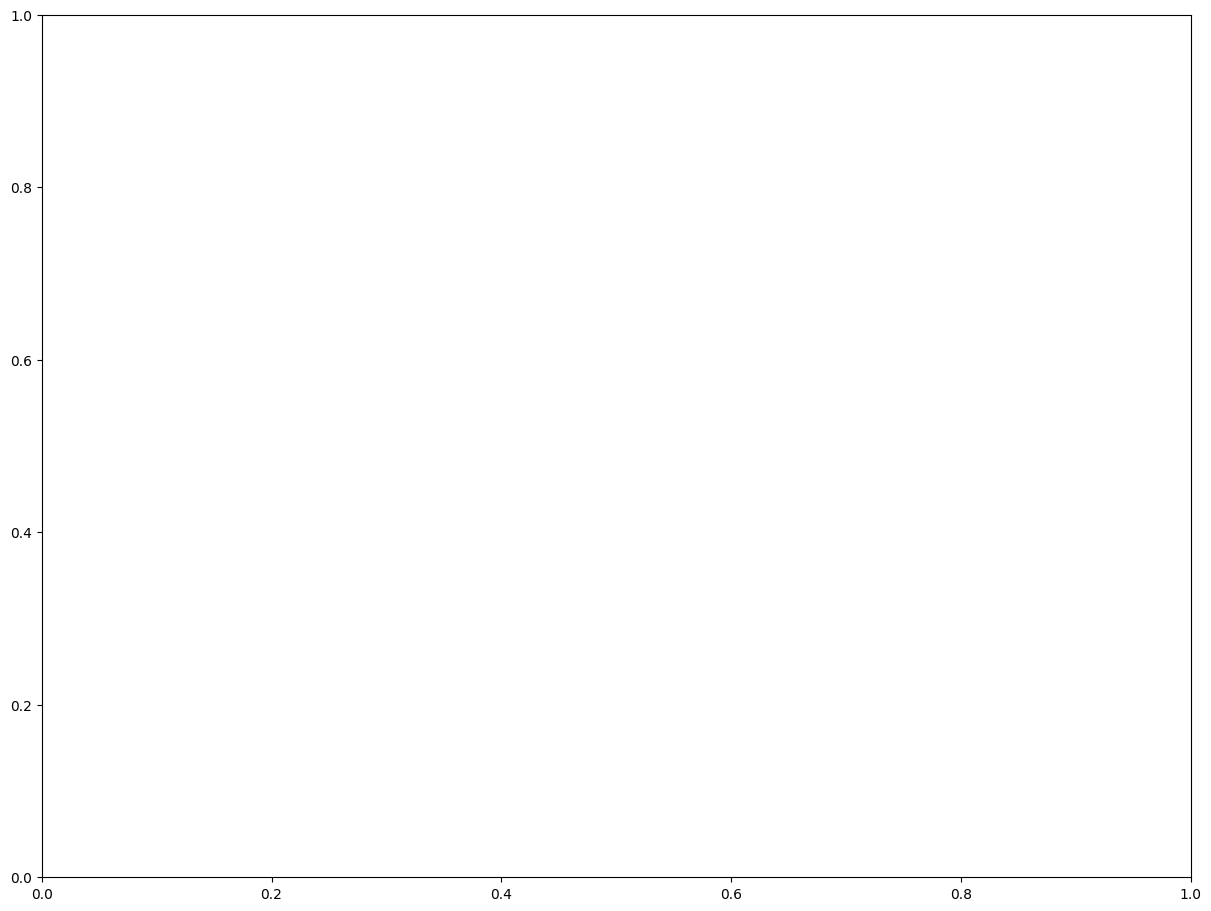

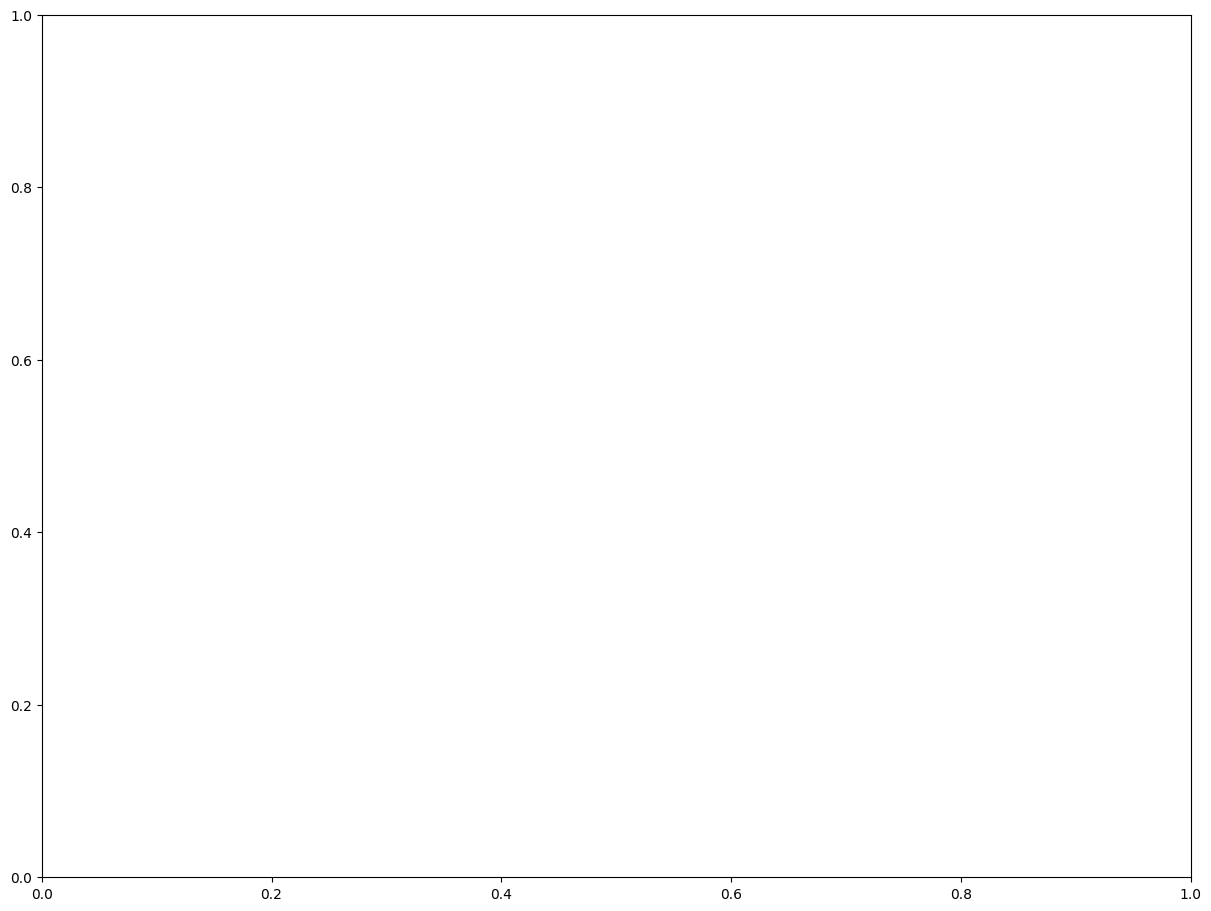

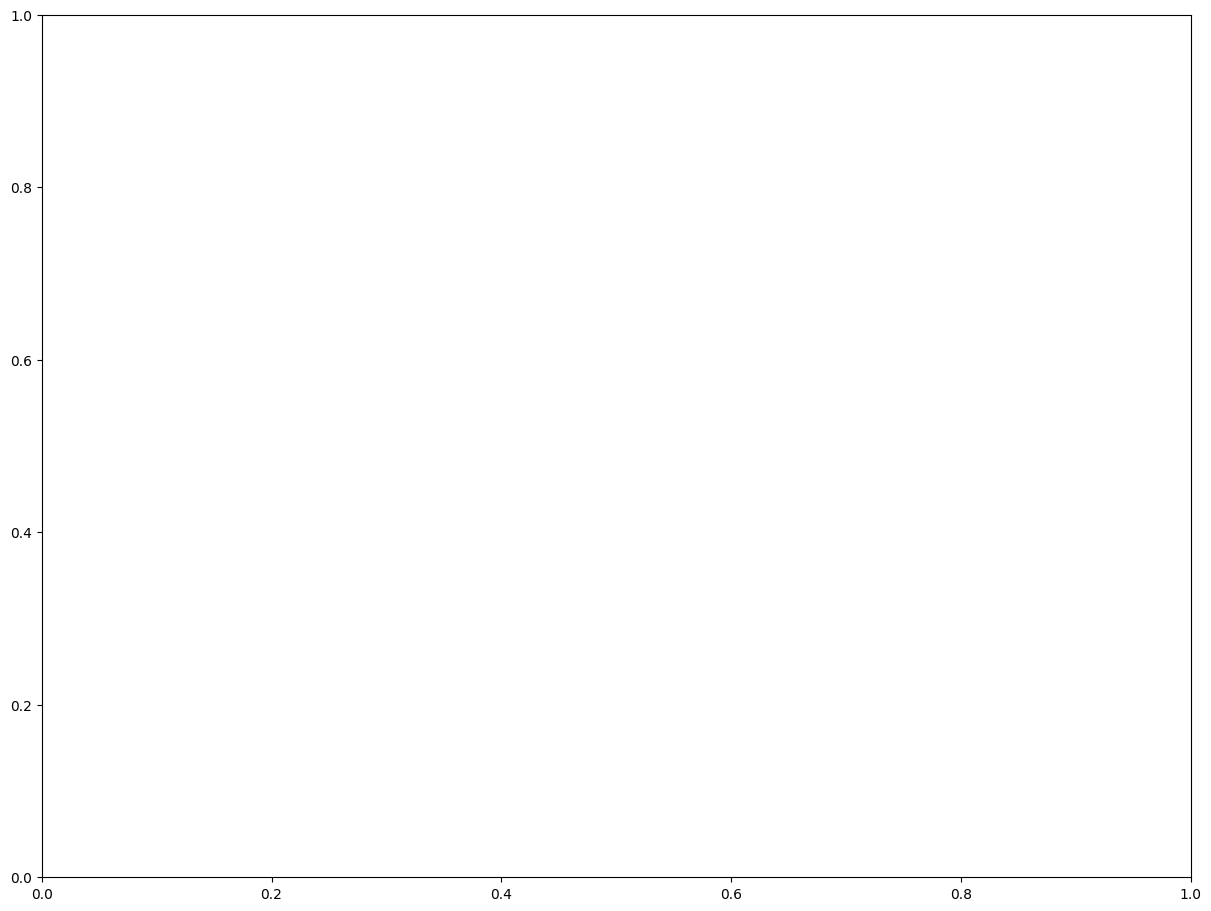

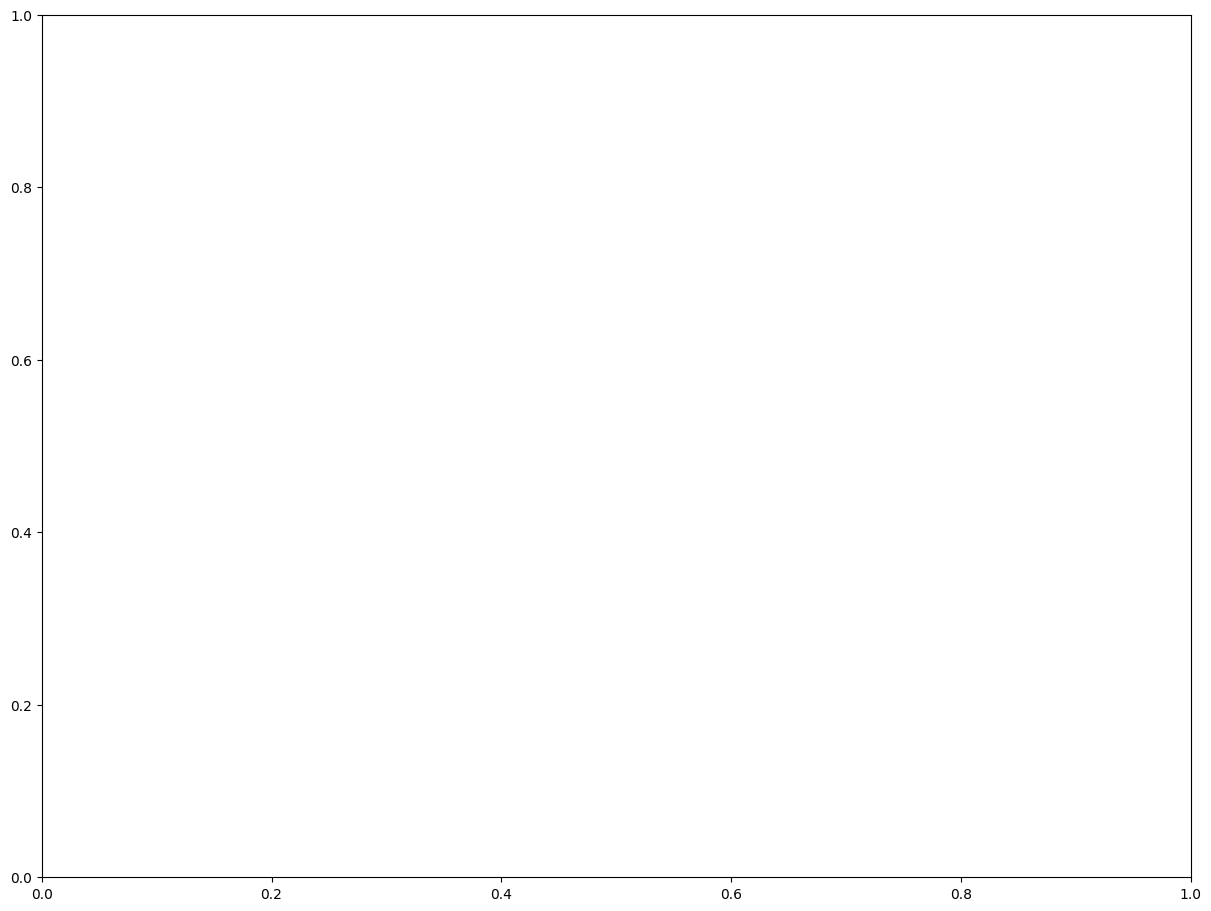

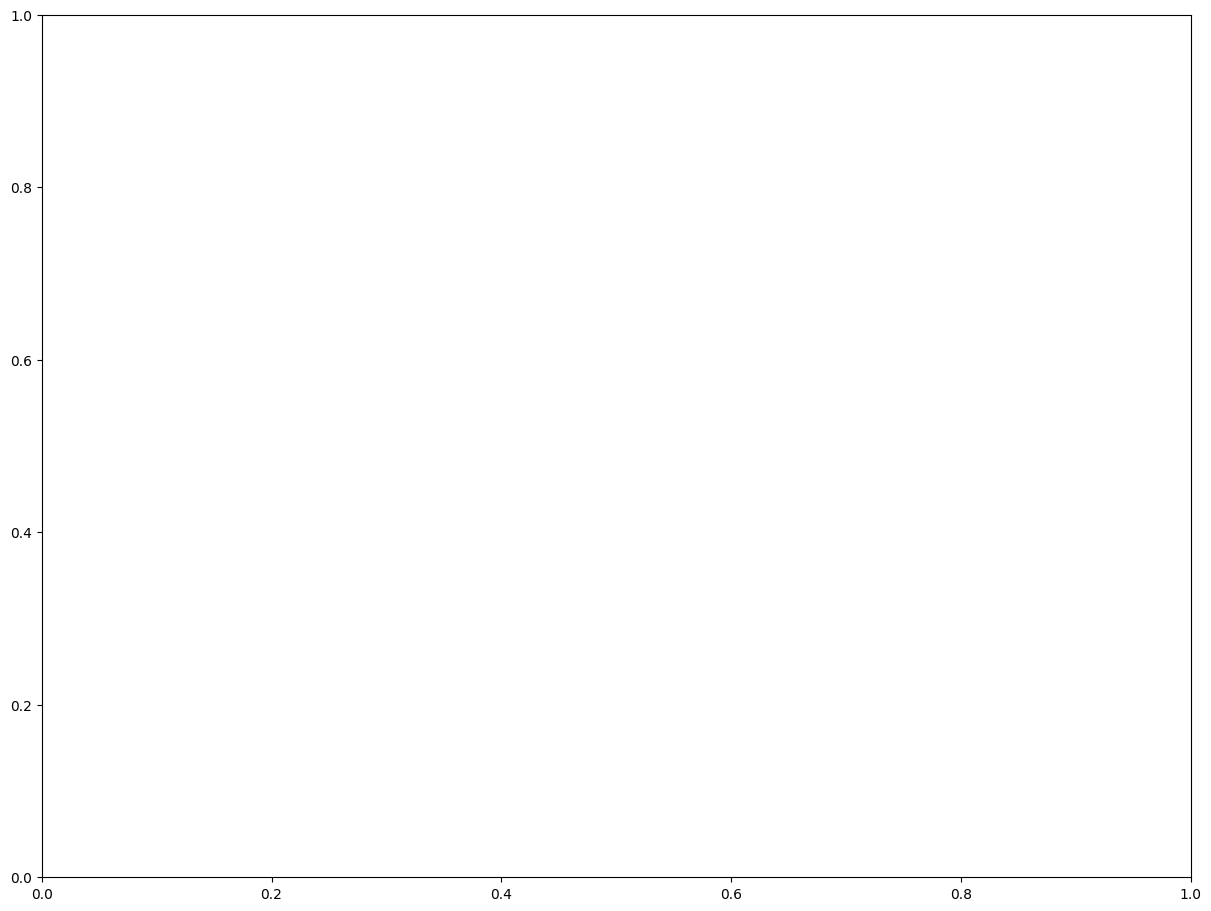

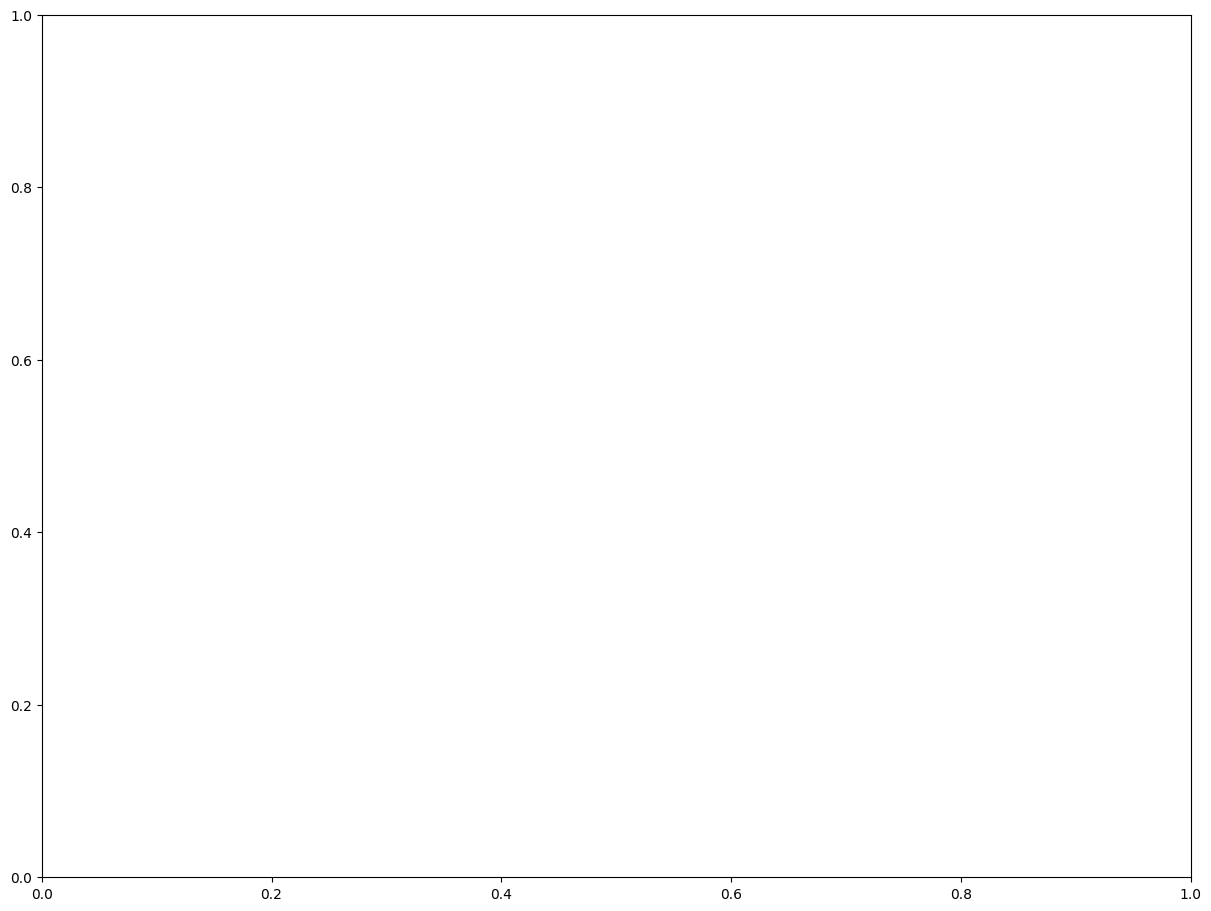

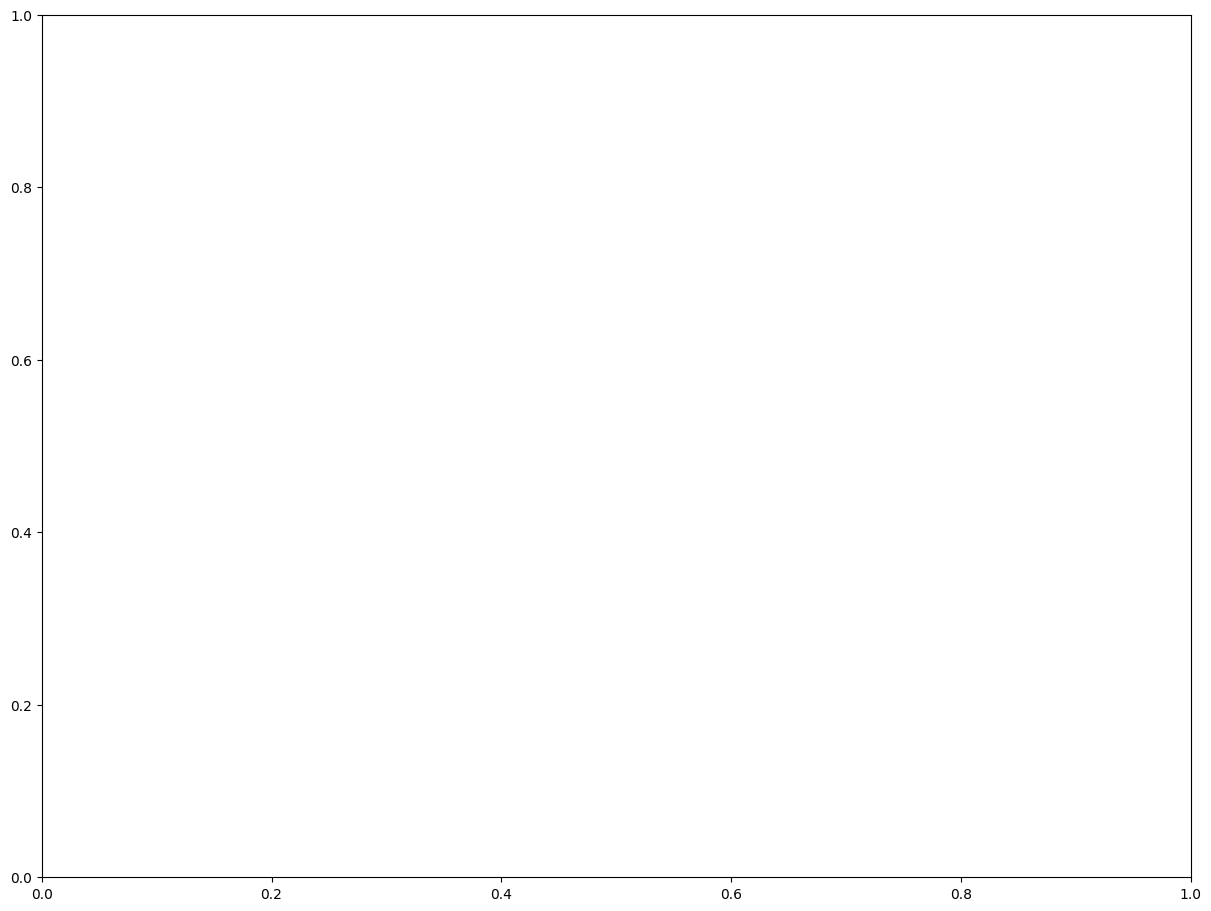

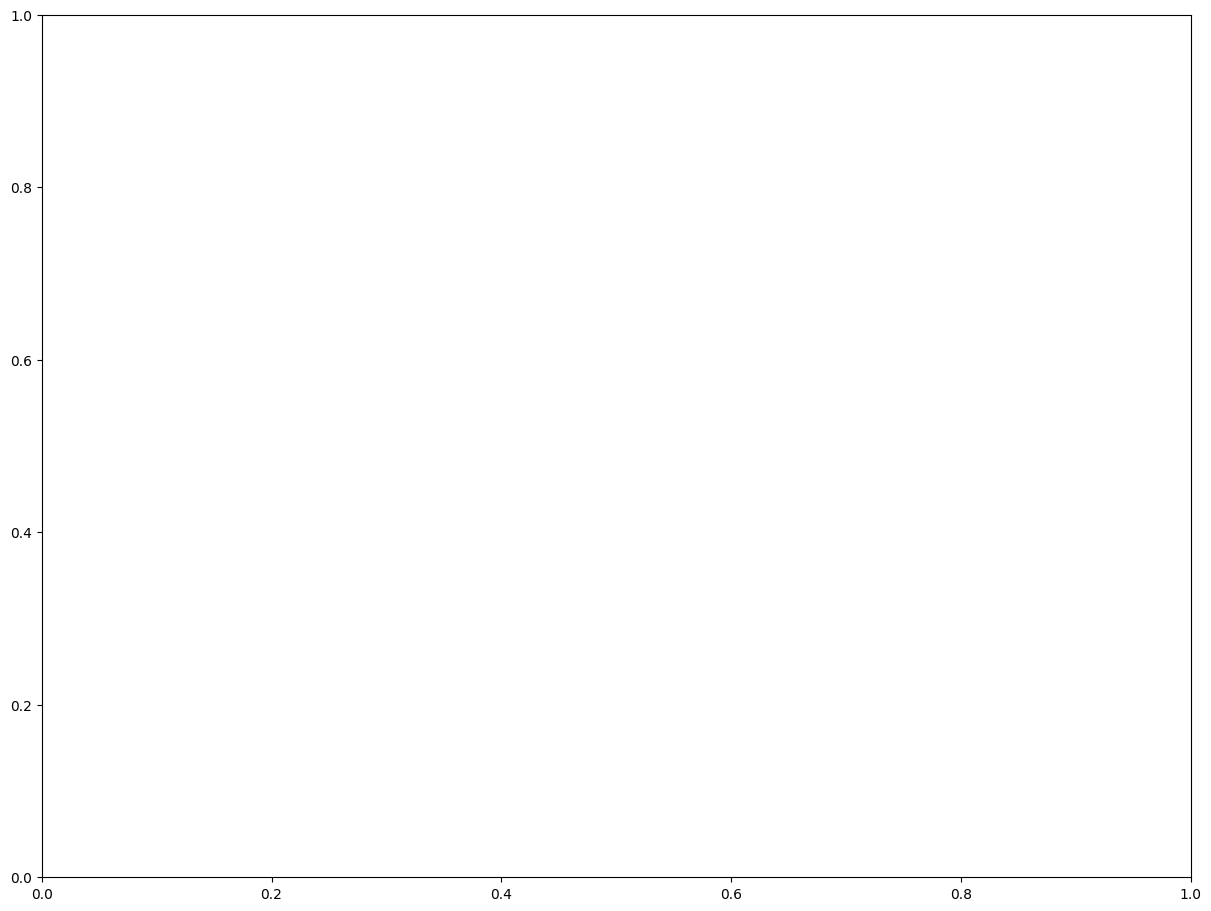

In [49]:
for img in coco_dict["images"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 9), constrained_layout=True)

    mono_img = Image.open(os.path.join(IMAGE_DIR, img["file_name"])).convert("L")
    rgb_img = Image.merge("RGB", (mono_img, mono_img, mono_img))

    # iterate over all annotations
    for ann_ind in range(len(coco_dict["annotations"])):
        
        if coco_dict["annotations"][ann_ind]["image_id"] == img["id"]:
            # convert coco bbox to pil bbox
            xywh = coco_dict["annotations"][ann_ind]["bbox"]
            xyxy = [xywh[0], xywh[1], xywh[0]+xywh[2], xywh[1]+xywh[3]]

            # visualize bbox over image
            ImageDraw.Draw(rgb_img).rectangle(xyxy, width=5, outline="lime")

    ax.axis("off")
    ax.imshow(rgb_img)
    fig.savefig(os.path.join(VISUALISATION_PATH, img["file_name"][:-4] + ".png"))
    
    plt.clf()
    plt.cla()

In [ ]:
class OriginalImageAugmentor:
    def __init__(self, data_dir, augmentation_config, coco_file_name):
        # Initialize paths and directories
        self.data_dir = data_dir
        self.coco_file_name = coco_file_name
        self.org_annotation_path = os.path.join(data_dir, f"{coco_file_name}_corrected_coco.json")
        self.image_dir = os.path.join(data_dir, "images")
        self.output_dir = os.path.join(data_dir, "augmentation", "original_images")
        self.bbox_visualization_dir = os.path.join(data_dir, "bbox_vis", coco_file_name)
        
        # Ensure directories exist
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.bbox_visualization_dir, exist_ok=True)
        
        # Define augmentation pipeline
        self.augmentation_pipeline = self._create_augmentation_pipeline(**augmentation_config)
        
        # Load COCO annotations
        self.coco_dict = load_json(self.org_annotation_path)
        self._update_image_paths()
    
    def _create_augmentation_pipeline(self, horizontal_flip, brightness_contrast, rotate, blur, normalize):
        # Define an augmentation pipeline based on provided configuration
        return A.Compose([
            A.HorizontalFlip(p=horizontal_flip),
            A.RandomBrightnessContrast(p=brightness_contrast),
            A.ShiftScaleRotate(rotate_limit=rotate, p=0.5),
            A.Blur(blur_limit=blur, p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
    
    def _update_image_paths(self):
        # Update image paths to ensure consistency
        for img in self.coco_dict["images"]:
            img["file_name"] = os.path.splitext(img["file_name"])[0] + ".png"
        save_json(self.coco_dict, self.org_annotation_path)
    
    def augment_image(self, image, bboxes, class_labels):
        # Apply augmentation to an image
        return self.augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)

    def process_images(self):
        for img in self.coco_dict["images"]:
            image_path = os.path.join(self.image_dir, img["file_name"])
            if not os.path.exists(image_path):
                print(f"Warning: Image {img['file_name']} not found.")
                continue

            # Load and prepare the image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Get bounding boxes and labels for this image
            bboxes, class_labels = [], []
            for annotation in self.coco_dict["annotations"]:
                if annotation["image_id"] == img["id"]:
                    x, y, w, h = annotation["bbox"]
                    bboxes.append([x, y, w, h])
                    class_labels.append(annotation["category_id"])

            # Apply augmentation
            augmented = self.augment_image(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = augmented['bboxes']

            # Save augmented image and visualize bounding boxes
            self.save_augmented_image(augmented_image, img["file_name"])
            self.visualize_bboxes(augmented_image, augmented_bboxes, img["file_name"])

    def save_augmented_image(self, image, filename):
        # Save the augmented image
        output_path = os.path.join(self.output_dir, filename)
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert from CHW to HWC format
        image = (image * 255).astype('uint8')
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    def visualize_bboxes(self, image, bboxes, filename):
        # Visualize and save bounding boxes on the augmented image
        fig, ax = plt.subplots()
        ax.imshow(image.permute(1, 2, 0))  # CHW to HWC for plotting

        for bbox in bboxes:
            x_min, y_min, width, height = bbox
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Save visualization
        output_path = os.path.join(self.bbox_visualization_dir, f"{filename[:-4]}_augmented.png")
        plt.savefig(output_path)
        plt.close(fig)

In [51]:
augmentation_config = {
    'horizontal_flip': 0.5,
    'brightness_contrast': 0.5,
    'rotate': 30,
    'blur': 3,
    'normalize': True
}